In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report
from itertools import product
from tqdm import tqdm


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marcuskrarup/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load data

In [3]:
# Import Ekman emotions to DataFrame
df_train_ekman = pd.read_csv('data/ekman_train.csv')
df_val_ekman = pd.read_csv('data/ekman_val.csv')
df_test_ekman = pd.read_csv('data/ekman_test.csv')



In [4]:
# Count occurrences for each emotion in train, test, and val datasets
train_counts = df_train_ekman.iloc[:, 1:].sum()
test_counts = df_test_ekman.iloc[:, 1:].sum()
val_counts = df_val_ekman.iloc[:, 1:].sum()

print("Train Counts:\n", train_counts)
print("\nTest Counts:\n", test_counts)
print("\nValidation Counts:\n", val_counts)

Train Counts:
 anger        4824
disgust       818
fear          695
joy         13877
neutral      9290
sadness      2967
surprise     4783
dtype: int64

Test Counts:
 anger       1635
disgust      281
fear         257
joy         4622
neutral     3046
sadness     1042
surprise    1638
dtype: int64

Validation Counts:
 anger       1568
disgust      250
fear         258
joy         4599
neutral     3152
sadness      977
surprise    1636
dtype: int64


# Text preprocessing

In [5]:
def preprocess(text):
    return word_tokenize(text.lower())

# Build vocab

In [6]:
tokenized_texts = df_train_ekman['text'].apply(preprocess)
word_counts = Counter(token for tokens in tokenized_texts for token in tokens)
vocab = {word: i + 2 for i, (word, _) in enumerate(word_counts.items())}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def encode(text):
    return [vocab.get(t, vocab['<UNK>']) for t in preprocess(text)]

# Dataset

In [7]:
class EmotionDataset(Dataset):
    def __init__(self, df):
        self.X = [torch.tensor(encode(text)) for text in df['text']]
        self.y = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_seqs = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded_seqs, torch.stack(labels)

train_loader = DataLoader(EmotionDataset(df_train_ekman), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(EmotionDataset(df_val_ekman), batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(EmotionDataset(df_test_ekman), batch_size=32, collate_fn=collate_fn)

# Model

In [8]:
class EmotionLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return self.sigmoid(out)

# Initialize

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EmotionLSTM(len(vocab), embed_dim=100, hidden_dim=128, output_dim=7).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop

In [10]:
for epoch in range(5):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 400.4238
Epoch 2, Loss: 360.8750
Epoch 3, Loss: 334.5906
Epoch 4, Loss: 309.7308
Epoch 5, Loss: 283.6579


# Evaluation (Validation or Test)

In [11]:
for epoch in range(5):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 255.9115
Epoch 2, Loss: 226.8393
Epoch 3, Loss: 199.0102
Epoch 4, Loss: 174.0240
Epoch 5, Loss: 153.6952


In [12]:
def evaluate(loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            preds = (preds > 0.5).float()
            correct += (preds == y_batch).sum().item()
            total += torch.numel(y_batch)
    print(f"Accuracy: {correct / total:.4f}")

In [13]:
evaluate(
    model = model.to(device),
    data_loader = val_loader,  
    criterion = criterion,
    device = device,
)

TypeError: evaluate() got an unexpected keyword argument 'model'

In [14]:
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

In [17]:
epochs = 5  # Define the number of epochs
for epoch in range(epochs):
    model.train()
    running_loss = 0
    correct, total = 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Accuracy
        predicted = (preds > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += torch.numel(y_batch)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total * 100

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()
            predicted = (preds > 0.5).float()
            val_correct += (predicted == y_batch).sum().item()
            val_total += torch.numel(y_batch)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total * 100

    # Record history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


Epoch 1/5 | Train Loss: 0.1254, Val Loss: 0.4791, Train Acc: 95.54%, Val Acc: 84.82%
Epoch 2/5 | Train Loss: 0.1106, Val Loss: 0.5153, Train Acc: 96.12%, Val Acc: 84.47%
Epoch 3/5 | Train Loss: 0.0997, Val Loss: 0.5360, Train Acc: 96.53%, Val Acc: 84.66%
Epoch 4/5 | Train Loss: 0.0903, Val Loss: 0.5520, Train Acc: 96.88%, Val Acc: 84.47%
Epoch 5/5 | Train Loss: 0.0805, Val Loss: 0.5943, Train Acc: 97.23%, Val Acc: 84.06%


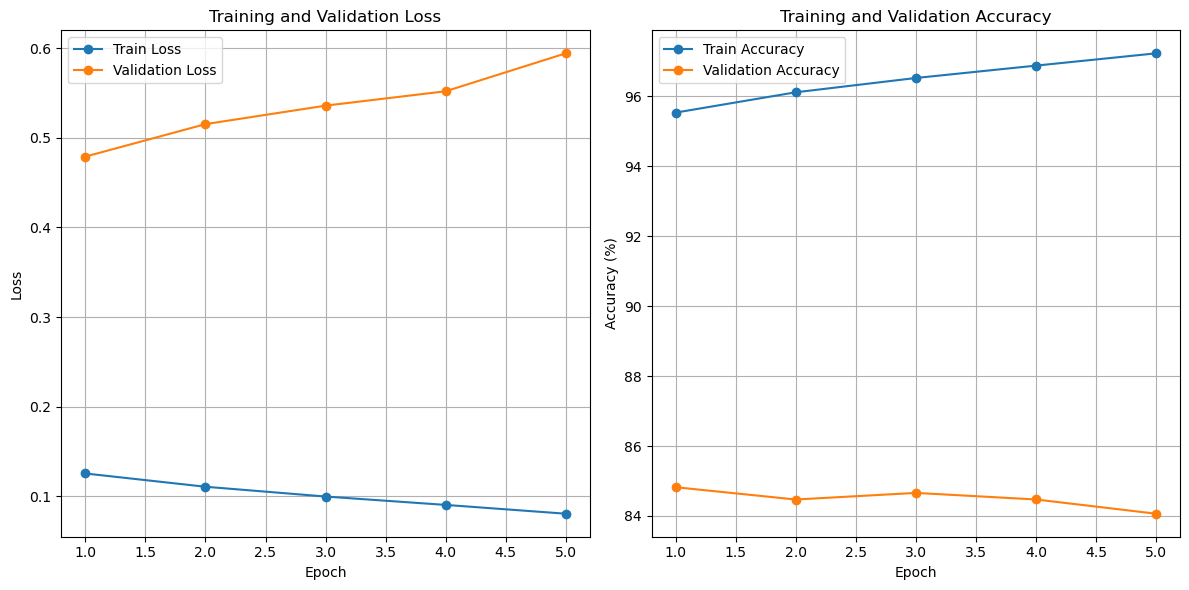

In [18]:
def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [19]:
print("Test:")
evaluate(test_loader)

Test:
Accuracy: 0.8396


In [20]:
from sklearn.metrics import classification_report

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = (outputs > 0.5).float()

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert to arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Emotion class names in order
class_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Print classification report
print("\nClassification Report (Multi-label):")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))



Classification Report (Multi-label):
              precision    recall  f1-score   support

       anger       0.28      0.34      0.31      1635
     disgust       0.14      0.07      0.10       281
        fear       0.36      0.11      0.16       257
         joy       0.65      0.64      0.64      4622
     neutral       0.40      0.30      0.34      3046
     sadness       0.45      0.27      0.33      1042
    surprise       0.39      0.33      0.36      1638

   micro avg       0.48      0.42      0.45     12521
   macro avg       0.38      0.29      0.32     12521
weighted avg       0.47      0.42      0.44     12521
 samples avg       0.43      0.43      0.42     12521



In [21]:
import numpy as np
from sklearn.metrics import classification_report

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = (outputs > 0.5).float()
        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

class_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

print("\nClassification Report (Multi-label):")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))



Classification Report (Multi-label):
              precision    recall  f1-score   support

       anger       0.28      0.34      0.31      1635
     disgust       0.14      0.07      0.10       281
        fear       0.36      0.11      0.16       257
         joy       0.65      0.64      0.64      4622
     neutral       0.40      0.30      0.34      3046
     sadness       0.45      0.27      0.33      1042
    surprise       0.39      0.33      0.36      1638

   micro avg       0.48      0.42      0.45     12521
   macro avg       0.38      0.29      0.32     12521
weighted avg       0.47      0.42      0.44     12521
 samples avg       0.43      0.43      0.42     12521



# Hyperparameter tuning

In [29]:
def run_grid_search(df_train_ekman, df_val_ekman, vocab):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_config = None
    best_val_acc = 0
    best_history = None
    best_model = None

    # Hyperparameter grid
    hidden_dims = [64, 128]
    batch_sizes = [16, 32]
    epochs_list = [3, 10]

    for hidden_dim, batch_size, epochs in tqdm(product(hidden_dims, batch_sizes, epochs_list), total=8):
        print(f"\nTraining: hidden_dim={hidden_dim}, batch_size={batch_size}, epochs={epochs}")

        train_loader = DataLoader(EmotionDataset(df_train_ekman), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(EmotionDataset(df_val_ekman), batch_size=batch_size, collate_fn=collate_fn)

        model = EmotionLSTM(len(vocab), embed_dim=100, hidden_dim=hidden_dim, output_dim=7).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)

        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

        for epoch in range(epochs):
            model.train()
            total_loss = 0
            correct, total = 0, 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                preds = model(X_batch)
                loss = criterion(preds, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                predicted = (preds > 0.5).float()
                correct += (predicted == y_batch).sum().item()
                total += torch.numel(y_batch)

            train_loss = total_loss / len(train_loader)
            train_acc = correct / total * 100

            model.eval()
            val_loss, val_correct, val_total = 0, 0, 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    preds = model(X_batch)
                    val_loss += criterion(preds, y_batch).item()
                    predicted = (preds > 0.5).float()
                    val_correct += (predicted == y_batch).sum().item()
                    val_total += torch.numel(y_batch)

            val_loss /= len(val_loader)
            val_acc = val_correct / val_total * 100

            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            history["train_acc"].append(train_acc)
            history["val_acc"].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_config = (hidden_dim, batch_size, epochs)
            best_history = {
                "train_loss": history["train_loss"].copy(),
                "val_loss": history["val_loss"].copy(),
                "train_acc": history["train_acc"].copy(),
                "val_acc": history["val_acc"].copy()
            }
            best_model = model

    print("\n✅ Best configuration:")
    print(f"Hidden Dim: {best_config[0]}, Batch Size: {best_config[1]}, Epochs: {best_config[2]}")
    print(f"Validation Accuracy: {best_val_acc:.2f}%")

    return best_config, best_history, best_model


In [30]:
run_grid_search(df_train_ekman, df_val_ekman, vocab)



  0%|          | 0/8 [00:00<?, ?it/s]


Training: hidden_dim=64, batch_size=16, epochs=3
Epoch 1/3 | Train Loss: 0.3585, Val Loss: 0.3446, Train Acc: 85.27%, Val Acc: 86.00%
Epoch 2/3 | Train Loss: 0.3383, Val Loss: 0.3417, Train Acc: 86.43%, Val Acc: 86.23%


 12%|█▎        | 1/8 [00:58<06:46, 58.13s/it]

Epoch 3/3 | Train Loss: 0.3272, Val Loss: 0.3393, Train Acc: 86.90%, Val Acc: 86.29%

Training: hidden_dim=64, batch_size=16, epochs=10
Epoch 1/10 | Train Loss: 0.3638, Val Loss: 0.3556, Train Acc: 84.74%, Val Acc: 85.53%
Epoch 2/10 | Train Loss: 0.3461, Val Loss: 0.3453, Train Acc: 85.95%, Val Acc: 85.94%
Epoch 3/10 | Train Loss: 0.3355, Val Loss: 0.3434, Train Acc: 86.54%, Val Acc: 86.11%
Epoch 4/10 | Train Loss: 0.3255, Val Loss: 0.3425, Train Acc: 86.97%, Val Acc: 86.26%
Epoch 5/10 | Train Loss: 0.3183, Val Loss: 0.3458, Train Acc: 87.27%, Val Acc: 86.16%
Epoch 6/10 | Train Loss: 0.3140, Val Loss: 0.3499, Train Acc: 87.45%, Val Acc: 85.85%
Epoch 7/10 | Train Loss: 0.3089, Val Loss: 0.3507, Train Acc: 87.68%, Val Acc: 86.03%
Epoch 8/10 | Train Loss: 0.3061, Val Loss: 0.3488, Train Acc: 87.76%, Val Acc: 86.10%
Epoch 9/10 | Train Loss: 0.2998, Val Loss: 0.3537, Train Acc: 88.09%, Val Acc: 86.06%


 25%|██▌       | 2/8 [04:24<14:32, 145.35s/it]

Epoch 10/10 | Train Loss: 0.2968, Val Loss: 0.3545, Train Acc: 88.26%, Val Acc: 85.93%

Training: hidden_dim=64, batch_size=32, epochs=3
Epoch 1/3 | Train Loss: 0.3627, Val Loss: 0.3476, Train Acc: 84.91%, Val Acc: 85.90%
Epoch 2/3 | Train Loss: 0.3368, Val Loss: 0.3382, Train Acc: 86.47%, Val Acc: 86.40%


 38%|███▊      | 3/8 [05:00<07:56, 95.24s/it] 

Epoch 3/3 | Train Loss: 0.3224, Val Loss: 0.3337, Train Acc: 87.06%, Val Acc: 86.53%

Training: hidden_dim=64, batch_size=32, epochs=10
Epoch 1/10 | Train Loss: 0.3600, Val Loss: 0.3481, Train Acc: 85.38%, Val Acc: 86.10%
Epoch 2/10 | Train Loss: 0.3387, Val Loss: 0.3371, Train Acc: 86.47%, Val Acc: 86.51%
Epoch 3/10 | Train Loss: 0.3277, Val Loss: 0.3388, Train Acc: 86.83%, Val Acc: 86.26%
Epoch 4/10 | Train Loss: 0.3161, Val Loss: 0.3373, Train Acc: 87.29%, Val Acc: 86.42%
Epoch 5/10 | Train Loss: 0.3042, Val Loss: 0.3420, Train Acc: 87.88%, Val Acc: 86.25%
Epoch 6/10 | Train Loss: 0.2944, Val Loss: 0.3466, Train Acc: 88.36%, Val Acc: 85.97%
Epoch 7/10 | Train Loss: 0.2857, Val Loss: 0.3550, Train Acc: 88.72%, Val Acc: 85.78%
Epoch 8/10 | Train Loss: 0.2771, Val Loss: 0.3583, Train Acc: 89.16%, Val Acc: 85.62%
Epoch 9/10 | Train Loss: 0.2699, Val Loss: 0.3586, Train Acc: 89.45%, Val Acc: 85.60%


 50%|█████     | 4/8 [06:53<06:49, 102.48s/it]

Epoch 10/10 | Train Loss: 0.2639, Val Loss: 0.3637, Train Acc: 89.71%, Val Acc: 85.71%

Training: hidden_dim=128, batch_size=16, epochs=3
Epoch 1/3 | Train Loss: 0.3589, Val Loss: 0.3466, Train Acc: 85.15%, Val Acc: 86.04%
Epoch 2/3 | Train Loss: 0.3364, Val Loss: 0.3370, Train Acc: 86.56%, Val Acc: 86.42%


 62%|██████▎   | 5/8 [08:06<04:35, 91.73s/it] 

Epoch 3/3 | Train Loss: 0.3247, Val Loss: 0.3342, Train Acc: 87.00%, Val Acc: 86.63%

Training: hidden_dim=128, batch_size=16, epochs=10
Epoch 1/10 | Train Loss: 0.3625, Val Loss: 0.3516, Train Acc: 84.89%, Val Acc: 85.64%
Epoch 2/10 | Train Loss: 0.3475, Val Loss: 0.3508, Train Acc: 86.00%, Val Acc: 85.78%
Epoch 3/10 | Train Loss: 0.3346, Val Loss: 0.3476, Train Acc: 86.52%, Val Acc: 85.96%
Epoch 4/10 | Train Loss: 0.3277, Val Loss: 0.3463, Train Acc: 86.87%, Val Acc: 85.89%
Epoch 5/10 | Train Loss: 0.3228, Val Loss: 0.3449, Train Acc: 87.05%, Val Acc: 86.13%
Epoch 6/10 | Train Loss: 0.3175, Val Loss: 0.3476, Train Acc: 87.25%, Val Acc: 86.04%
Epoch 7/10 | Train Loss: 0.3128, Val Loss: 0.3493, Train Acc: 87.53%, Val Acc: 85.71%
Epoch 8/10 | Train Loss: 0.3096, Val Loss: 0.3544, Train Acc: 87.70%, Val Acc: 85.82%
Epoch 9/10 | Train Loss: 0.3064, Val Loss: 0.3527, Train Acc: 87.81%, Val Acc: 85.61%


 75%|███████▌  | 6/8 [12:13<04:48, 144.42s/it]

Epoch 10/10 | Train Loss: 0.3047, Val Loss: 0.3528, Train Acc: 87.93%, Val Acc: 85.74%

Training: hidden_dim=128, batch_size=32, epochs=3
Epoch 1/3 | Train Loss: 0.3644, Val Loss: 0.3516, Train Acc: 84.73%, Val Acc: 85.67%
Epoch 2/3 | Train Loss: 0.3425, Val Loss: 0.3393, Train Acc: 86.13%, Val Acc: 86.33%


 88%|████████▊ | 7/8 [13:13<01:57, 117.10s/it]

Epoch 3/3 | Train Loss: 0.3261, Val Loss: 0.3328, Train Acc: 86.89%, Val Acc: 86.54%

Training: hidden_dim=128, batch_size=32, epochs=10
Epoch 1/10 | Train Loss: 0.3679, Val Loss: 0.3586, Train Acc: 84.68%, Val Acc: 85.44%
Epoch 2/10 | Train Loss: 0.3437, Val Loss: 0.3352, Train Acc: 86.18%, Val Acc: 86.62%
Epoch 3/10 | Train Loss: 0.3234, Val Loss: 0.3312, Train Acc: 87.12%, Val Acc: 86.73%
Epoch 4/10 | Train Loss: 0.3106, Val Loss: 0.3272, Train Acc: 87.56%, Val Acc: 86.80%
Epoch 5/10 | Train Loss: 0.3002, Val Loss: 0.3317, Train Acc: 87.91%, Val Acc: 86.64%
Epoch 6/10 | Train Loss: 0.2905, Val Loss: 0.3388, Train Acc: 88.33%, Val Acc: 86.23%
Epoch 7/10 | Train Loss: 0.2819, Val Loss: 0.3422, Train Acc: 88.72%, Val Acc: 86.21%
Epoch 8/10 | Train Loss: 0.2733, Val Loss: 0.3477, Train Acc: 89.06%, Val Acc: 85.70%
Epoch 9/10 | Train Loss: 0.2661, Val Loss: 0.3490, Train Acc: 89.36%, Val Acc: 86.13%


100%|██████████| 8/8 [16:26<00:00, 123.25s/it]

Epoch 10/10 | Train Loss: 0.2597, Val Loss: 0.3518, Train Acc: 89.67%, Val Acc: 86.05%

✅ Best configuration:
Hidden Dim: 128, Batch Size: 16, Epochs: 3
Validation Accuracy: 86.63%


((128, 16, 3),
 {'train_loss': [0.3589162544551678, 0.3363604684211916, 0.32468760512579947],
  'val_loss': [0.3465562712328916, 0.33695102169325475, 0.3341888343899864],
  'train_acc': [85.14595860862967, 86.56141479630134, 86.99982677983718],
  'val_acc': [86.04461270088706, 86.41700379814175, 86.62856153113363]},
 EmotionLSTM(
   (embedding): Embedding(25935, 100, padding_idx=0)
   (lstm): LSTM(100, 128, batch_first=True)
   (fc): Linear(in_features=128, out_features=7, bias=True)
   (sigmoid): Sigmoid()
 ))

  0%|          | 0/8 [00:00<?, ?it/s]


Training: hidden_dim=64, batch_size=16, epochs=3
Epoch 1/3 | Train Loss: 0.3653, Val Loss: 0.3403, Train Acc: 84.89%, Val Acc: 86.60%
Epoch 2/3 | Train Loss: 0.3259, Val Loss: 0.3230, Train Acc: 87.08%, Val Acc: 86.99%


 12%|█▎        | 1/8 [00:59<06:54, 59.22s/it]

Epoch 3/3 | Train Loss: 0.3064, Val Loss: 0.3154, Train Acc: 87.69%, Val Acc: 87.17%

Training: hidden_dim=64, batch_size=16, epochs=5
Epoch 1/5 | Train Loss: 0.3655, Val Loss: 0.3426, Train Acc: 84.85%, Val Acc: 86.15%
Epoch 2/5 | Train Loss: 0.3195, Val Loss: 0.3154, Train Acc: 87.06%, Val Acc: 87.09%
Epoch 3/5 | Train Loss: 0.2938, Val Loss: 0.3069, Train Acc: 87.91%, Val Acc: 87.26%
Epoch 4/5 | Train Loss: 0.2704, Val Loss: 0.3116, Train Acc: 89.05%, Val Acc: 86.94%


 25%|██▌       | 2/8 [02:35<08:04, 80.81s/it]

Epoch 5/5 | Train Loss: 0.2466, Val Loss: 0.3218, Train Acc: 90.14%, Val Acc: 86.77%

Training: hidden_dim=64, batch_size=32, epochs=3
Epoch 1/3 | Train Loss: 0.3737, Val Loss: 0.3670, Train Acc: 84.46%, Val Acc: 84.61%
Epoch 2/3 | Train Loss: 0.3512, Val Loss: 0.3305, Train Acc: 85.67%, Val Acc: 86.78%


 38%|███▊      | 3/8 [03:11<05:03, 60.62s/it]

Epoch 3/3 | Train Loss: 0.3164, Val Loss: 0.3186, Train Acc: 87.31%, Val Acc: 87.13%

Training: hidden_dim=64, batch_size=32, epochs=5
Epoch 1/5 | Train Loss: 0.3734, Val Loss: 0.3653, Train Acc: 84.45%, Val Acc: 84.62%
Epoch 2/5 | Train Loss: 0.3350, Val Loss: 0.3219, Train Acc: 86.48%, Val Acc: 87.10%
Epoch 3/5 | Train Loss: 0.3074, Val Loss: 0.3126, Train Acc: 87.57%, Val Acc: 87.20%
Epoch 4/5 | Train Loss: 0.2861, Val Loss: 0.3103, Train Acc: 88.39%, Val Acc: 87.04%


 50%|█████     | 4/8 [04:10<03:59, 59.81s/it]

Epoch 5/5 | Train Loss: 0.2643, Val Loss: 0.3208, Train Acc: 89.37%, Val Acc: 86.92%

Training: hidden_dim=128, batch_size=16, epochs=3
Epoch 1/3 | Train Loss: 0.3604, Val Loss: 0.3330, Train Acc: 85.12%, Val Acc: 86.56%
Epoch 2/3 | Train Loss: 0.3208, Val Loss: 0.3227, Train Acc: 87.16%, Val Acc: 86.84%


 62%|██████▎   | 5/8 [05:26<03:16, 65.55s/it]

Epoch 3/3 | Train Loss: 0.2990, Val Loss: 0.3102, Train Acc: 87.89%, Val Acc: 87.23%

Training: hidden_dim=128, batch_size=16, epochs=5
Epoch 1/5 | Train Loss: 0.3602, Val Loss: 0.3289, Train Acc: 85.13%, Val Acc: 86.79%
Epoch 2/5 | Train Loss: 0.3165, Val Loss: 0.3128, Train Acc: 87.25%, Val Acc: 87.19%
Epoch 3/5 | Train Loss: 0.2933, Val Loss: 0.3055, Train Acc: 87.98%, Val Acc: 87.26%
Epoch 4/5 | Train Loss: 0.2682, Val Loss: 0.3098, Train Acc: 89.10%, Val Acc: 87.18%


 75%|███████▌  | 6/8 [07:45<03:01, 90.85s/it]

Epoch 5/5 | Train Loss: 0.2410, Val Loss: 0.3212, Train Acc: 90.40%, Val Acc: 86.78%

Training: hidden_dim=128, batch_size=32, epochs=3
Epoch 1/3 | Train Loss: 0.3719, Val Loss: 0.3672, Train Acc: 84.43%, Val Acc: 84.61%
Epoch 2/3 | Train Loss: 0.3405, Val Loss: 0.3231, Train Acc: 86.28%, Val Acc: 87.01%


 88%|████████▊ | 7/8 [08:45<01:20, 80.47s/it]

Epoch 3/3 | Train Loss: 0.3092, Val Loss: 0.3111, Train Acc: 87.50%, Val Acc: 87.16%

Training: hidden_dim=128, batch_size=32, epochs=5
Epoch 1/5 | Train Loss: 0.3717, Val Loss: 0.3686, Train Acc: 84.57%, Val Acc: 84.62%
Epoch 2/5 | Train Loss: 0.3403, Val Loss: 0.3219, Train Acc: 86.27%, Val Acc: 87.10%
Epoch 3/5 | Train Loss: 0.3089, Val Loss: 0.3107, Train Acc: 87.54%, Val Acc: 87.28%
Epoch 4/5 | Train Loss: 0.2858, Val Loss: 0.3099, Train Acc: 88.32%, Val Acc: 87.35%


100%|██████████| 8/8 [10:19<00:00, 77.47s/it]

Epoch 5/5 | Train Loss: 0.2618, Val Loss: 0.3117, Train Acc: 89.42%, Val Acc: 87.17%

✅ Best configuration:
Hidden Dim: 128, Batch Size: 16, Epochs: 3
Validation Accuracy: 87.23%


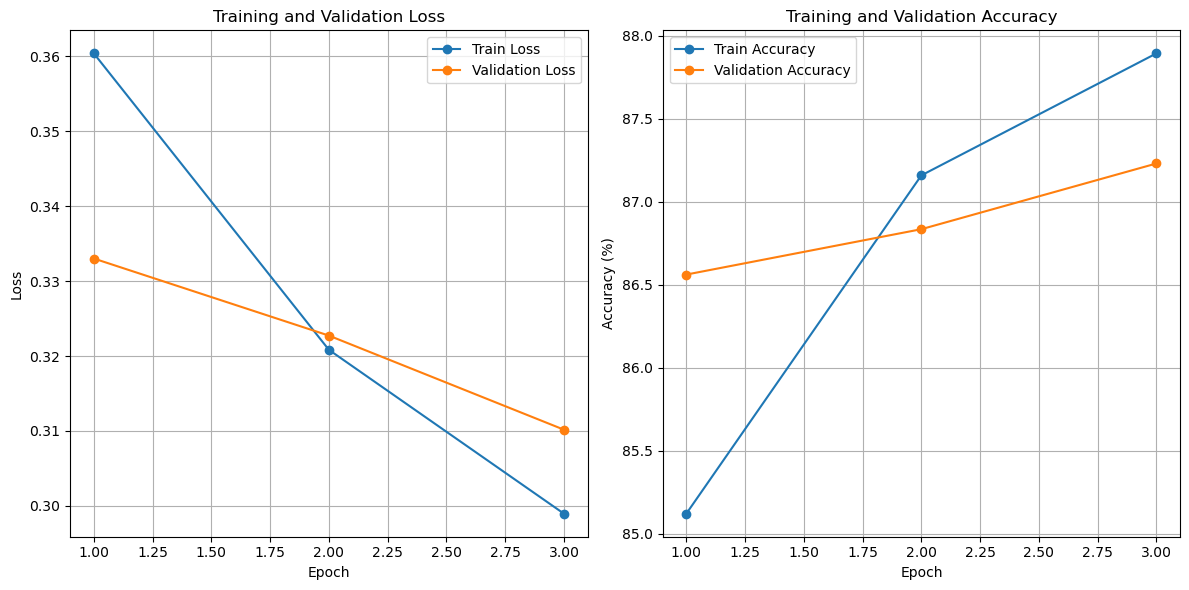

In [27]:
best_config, best_history, best_model = run_grid_search(df_train_ekman, df_val_ekman, vocab)
plot_training_history(best_history)



In [28]:
from sklearn.metrics import classification_report

# Unpack the best configuration
best_config, best_history, best_model = run_grid_search(df_train_ekman, df_val_ekman, vocab)

# Prepare test loader using the best batch size
_, best_batch_size, _ = best_config
test_loader = DataLoader(EmotionDataset(df_test_ekman), batch_size=best_batch_size, collate_fn=collate_fn)

# Evaluate on test set
best_model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = best_model(X_batch)
        preds = (outputs > 0.5).float()
        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Convert to arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Define class names
class_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

# Print detailed classification report
print("\nClassification Report (Multi-label, Test Set):")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))




  0%|          | 0/8 [00:00<?, ?it/s]


Training: hidden_dim=64, batch_size=16, epochs=3
Epoch 1/3 | Train Loss: 0.3672, Val Loss: 0.3408, Train Acc: 84.68%, Val Acc: 86.43%
Epoch 2/3 | Train Loss: 0.3239, Val Loss: 0.3180, Train Acc: 87.07%, Val Acc: 87.22%


 12%|█▎        | 1/8 [01:04<07:30, 64.38s/it]

Epoch 3/3 | Train Loss: 0.3009, Val Loss: 0.3115, Train Acc: 87.86%, Val Acc: 87.31%

Training: hidden_dim=64, batch_size=16, epochs=5
Epoch 1/5 | Train Loss: 0.3653, Val Loss: 0.3379, Train Acc: 84.84%, Val Acc: 86.33%
Epoch 2/5 | Train Loss: 0.3223, Val Loss: 0.3174, Train Acc: 87.11%, Val Acc: 87.19%
Epoch 3/5 | Train Loss: 0.2995, Val Loss: 0.3121, Train Acc: 87.89%, Val Acc: 87.26%
Epoch 4/5 | Train Loss: 0.2767, Val Loss: 0.3100, Train Acc: 88.81%, Val Acc: 87.08%


 25%|██▌       | 2/8 [02:42<08:23, 83.97s/it]

Epoch 5/5 | Train Loss: 0.2516, Val Loss: 0.3258, Train Acc: 89.99%, Val Acc: 86.77%

Training: hidden_dim=64, batch_size=32, epochs=3
Epoch 1/3 | Train Loss: 0.3737, Val Loss: 0.3647, Train Acc: 84.21%, Val Acc: 84.62%
Epoch 2/3 | Train Loss: 0.3403, Val Loss: 0.3313, Train Acc: 86.16%, Val Acc: 86.67%


 38%|███▊      | 3/8 [03:20<05:15, 63.18s/it]

Epoch 3/3 | Train Loss: 0.3106, Val Loss: 0.3287, Train Acc: 87.47%, Val Acc: 86.53%

Training: hidden_dim=64, batch_size=32, epochs=5
Epoch 1/5 | Train Loss: 0.3716, Val Loss: 0.3549, Train Acc: 84.32%, Val Acc: 85.55%
Epoch 2/5 | Train Loss: 0.3348, Val Loss: 0.3244, Train Acc: 86.65%, Val Acc: 87.10%
Epoch 3/5 | Train Loss: 0.3116, Val Loss: 0.3180, Train Acc: 87.54%, Val Acc: 87.08%
Epoch 4/5 | Train Loss: 0.2933, Val Loss: 0.3185, Train Acc: 88.21%, Val Acc: 86.88%


 50%|█████     | 4/8 [04:21<04:09, 62.30s/it]

Epoch 5/5 | Train Loss: 0.2738, Val Loss: 0.3197, Train Acc: 89.00%, Val Acc: 86.89%

Training: hidden_dim=128, batch_size=16, epochs=3
Epoch 1/3 | Train Loss: 0.3625, Val Loss: 0.3394, Train Acc: 84.98%, Val Acc: 86.22%
Epoch 2/3 | Train Loss: 0.3187, Val Loss: 0.3173, Train Acc: 87.14%, Val Acc: 87.10%


 62%|██████▎   | 5/8 [05:42<03:26, 68.98s/it]

Epoch 3/3 | Train Loss: 0.2953, Val Loss: 0.3107, Train Acc: 87.93%, Val Acc: 87.30%

Training: hidden_dim=128, batch_size=16, epochs=5
Epoch 1/5 | Train Loss: 0.3594, Val Loss: 0.3362, Train Acc: 85.27%, Val Acc: 86.47%
Epoch 2/5 | Train Loss: 0.3190, Val Loss: 0.3178, Train Acc: 87.20%, Val Acc: 87.04%
Epoch 3/5 | Train Loss: 0.2951, Val Loss: 0.3082, Train Acc: 87.99%, Val Acc: 87.16%
Epoch 4/5 | Train Loss: 0.2688, Val Loss: 0.3114, Train Acc: 89.17%, Val Acc: 87.10%


 75%|███████▌  | 6/8 [07:48<02:56, 88.38s/it]

Epoch 5/5 | Train Loss: 0.2396, Val Loss: 0.3225, Train Acc: 90.48%, Val Acc: 86.69%

Training: hidden_dim=128, batch_size=32, epochs=3
Epoch 1/3 | Train Loss: 0.3714, Val Loss: 0.3570, Train Acc: 84.52%, Val Acc: 85.47%
Epoch 2/3 | Train Loss: 0.3340, Val Loss: 0.3230, Train Acc: 86.69%, Val Acc: 86.99%


 88%|████████▊ | 7/8 [08:52<01:20, 80.41s/it]

Epoch 3/3 | Train Loss: 0.3060, Val Loss: 0.3150, Train Acc: 87.61%, Val Acc: 86.97%

Training: hidden_dim=128, batch_size=32, epochs=5
Epoch 1/5 | Train Loss: 0.3714, Val Loss: 0.3663, Train Acc: 84.50%, Val Acc: 84.62%
Epoch 2/5 | Train Loss: 0.3357, Val Loss: 0.3226, Train Acc: 86.35%, Val Acc: 86.93%
Epoch 3/5 | Train Loss: 0.3068, Val Loss: 0.3103, Train Acc: 87.54%, Val Acc: 87.17%
Epoch 4/5 | Train Loss: 0.2841, Val Loss: 0.3086, Train Acc: 88.39%, Val Acc: 87.22%


100%|██████████| 8/8 [10:32<00:00, 79.04s/it]

Epoch 5/5 | Train Loss: 0.2607, Val Loss: 0.3133, Train Acc: 89.46%, Val Acc: 86.95%

✅ Best configuration:
Hidden Dim: 64, Batch Size: 16, Epochs: 3
Validation Accuracy: 87.31%



Classification Report (Multi-label, Test Set):
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      1635
     disgust       0.00      0.00      0.00       281
        fear       0.00      0.00      0.00       257
         joy       0.76      0.61      0.68      4622
     neutral       0.52      0.20      0.28      3046
     sadness       0.81      0.03      0.06      1042
    surprise       0.59      0.22      0.32      1638

   micro avg       0.69      0.30      0.42     12521
   macro avg       0.38      0.15      0.19     12521
weighted avg       0.55      0.30      0.37     12521
 samples avg       0.33      0.31      0.32     12521

